# Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape

import tensorflow as tf
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Add

# Synthetic Data Generation

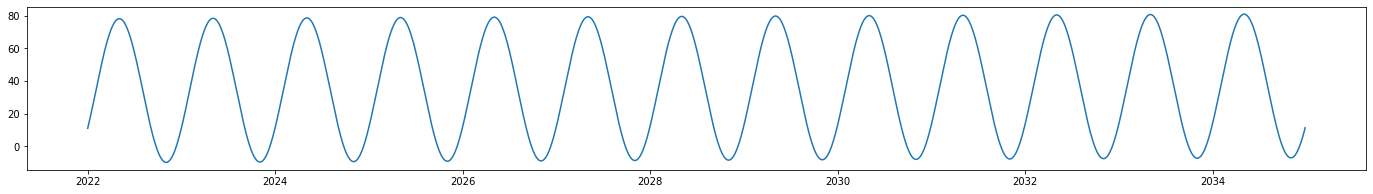

In [ ]:
n_years = np.random.randint(1, 15)
frequency = 2 * np.pi / 365.25
beta = 1
amplitude = np.random.randint(-100, 100)
elevation_power = 0
amplitude_change_power = 0
phase_shift = np.random.randint(-180, 180)
period_starts = pd.Timestamp('2022-01-01')
a = np.random.randint(-5, 5) / (n_years * 365.25)
b = np.random.randint(-100, 100)

duration_days = 365 * n_years
period_ends = period_starts + pd.Timedelta(days=duration_days)

x = np.linspace(1, duration_days, duration_days)#*24)
y = amplitude * np.sin(frequency * x + phase_shift)
# y = amplitude*(x**amplitude_change_power)*np.sin(x**beta*frequency)
y += a * x + b
y += -1 + x**elevation_power
x_date = pd.date_range(period_starts, period_ends, freq='D')[:-1]

plt.figure(figsize=(24,3))
plt.plot(x_date, y)
plt.show()

In [ ]:
# x = np.linspace(-10, 10, 100)
# y = x**2
# plt.plot(y)

In [ ]:
# x_date = np.array(x_date).reshape(-1,1)
# x = x.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1,1), y, shuffle=False)

# The SIN-based model

In [ ]:
def get_sb_model(
    y_train,
    wavelen=365.25,
    init_x_shift=1,
    init_y_shift='auto',
    init_amplitude='auto',
    learning_rate=10**-1,
    linear_trend=True,
    sin_components_trainable=True,
    trainability_map = None
    ):
  """single sin-based model"""

  default_trainability_map = {
    'linear_rotation': True,
    'linear_rotation_handler': True,
    'y_shift': True,
    'y_shift_amplifier': True,
    'frequency': False,
    'phase_shift': True,
    'phase_shift_amplifier': True,
    'sin': False,
    'amplitude': True,
    'output': False
    }

  if not trainability_map:
    trainability_map = default_trainability_map

  if init_amplitude == 'auto':
    init_amplitude = (y_train.max() - y_train.min()) / 2

  if init_y_shift == 'auto':
    init_y_shift = y_train.mean()

  adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  input_layer = Input(
      name='input',
      shape=X_train.shape[1]
      )

  frequency_layer = Dense(
      1,
      name='frequency',
      kernel_initializer=tf.keras.initializers.Constant(value=2*np.pi/wavelen),
      use_bias=False
      )(input_layer)

  phase_shift_layer = Dense(
      1,
      name='phase_shift',
      activation= lambda x: 0 * x + init_x_shift,
      use_bias=False,
      kernel_initializer=tf.keras.initializers.Constant(value=init_x_shift)
      )(input_layer)

  phase_shift_amplifier_layer = Dense(
      1,
      name='phase_shift_amplifier',
      use_bias=False,
      kernel_initializer=tf.keras.initializers.Constant(value=1)
      )(phase_shift_layer)

  sin_input_layer = Add(name='sin_input')(
      [
          frequency_layer,
          phase_shift_amplifier_layer
       ])

  sin_layer = Dense(
      1,
      name='sin',
      activation=lambda sin_input: tf.math.sin(sin_input),
      kernel_initializer=tf.keras.initializers.Constant(value=1),
      use_bias=False
      )(sin_input_layer)

  sin_amplitude_layer = Dense(
      1,
      name='amplitude',
      kernel_initializer=tf.keras.initializers.Constant(value=init_amplitude),
      use_bias=False
      )(sin_layer)

  linear_rotation_layer = Dense(
      1,
      name='linear_rotation',
      kernel_initializer=tf.keras.initializers.Constant(value=0),
      use_bias=False
      )(input_layer)

  linear_rotation_handler_layer = Dense(
      1,
      name='linear_rotation_handler',
      kernel_initializer=tf.keras.initializers.Constant(value=0),
      use_bias=False
      )(linear_rotation_layer)

  y_shift_layer = Dense(
      1,
      name='y_shift',
      activation= lambda x: 0 * x + init_y_shift,
      use_bias=False,
      kernel_initializer=tf.keras.initializers.Constant(value=init_y_shift)
      )(input_layer)


  y_shift_amplifier_layer = Dense(
      1,
      name='y_shift_amplifier',
      kernel_initializer=tf.keras.initializers.Constant(value=1),
      use_bias=False,
      )(y_shift_layer)

  linear_component_layer = Add(name='linear_component')([
      linear_rotation_handler_layer,
      y_shift_amplifier_layer
      ])

  output_layer = Add(name='output')([
      linear_component_layer,
      sin_amplitude_layer
      ])


  model = Model(inputs=input_layer, outputs=output_layer)

  for layer_name, trainability in trainability_map.items():
    model.get_layer(name=layer_name).trainable = trainability

  linear_components = [
      'linear_rotation',
      'linear_rotation_handler',
      'y_shift',
      'y_shift_amplifier'
      ]

  sin_components = [
      'frequency',
      'phase_shift',
      'phase_shift_amplifier',
      'sin',
      'amplitude'
      ]

  if not linear_trend:
    for layer_name in linear_components:
      model.get_layer(name=layer_name).trainable = False

  if not sin_components_trainable:
    for layer_name in sin_components:
      model.get_layer(name=layer_name).trainable = False

  model.compile(optimizer=adam, loss='mse')
  model.summary()
  return model

In [ ]:
model = get_sb_model(y_train)

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 phase_shift (Dense)            (None, 1)            1           ['input[0][0]']                  
                                                                                                  
 frequency (Dense)              (None, 1)            1           ['input[0][0]']                  
                                                                                                  
 phase_shift_amplifier (Dense)  (None, 1)            1           ['phase_shift[0][0]']            
                                                                                           

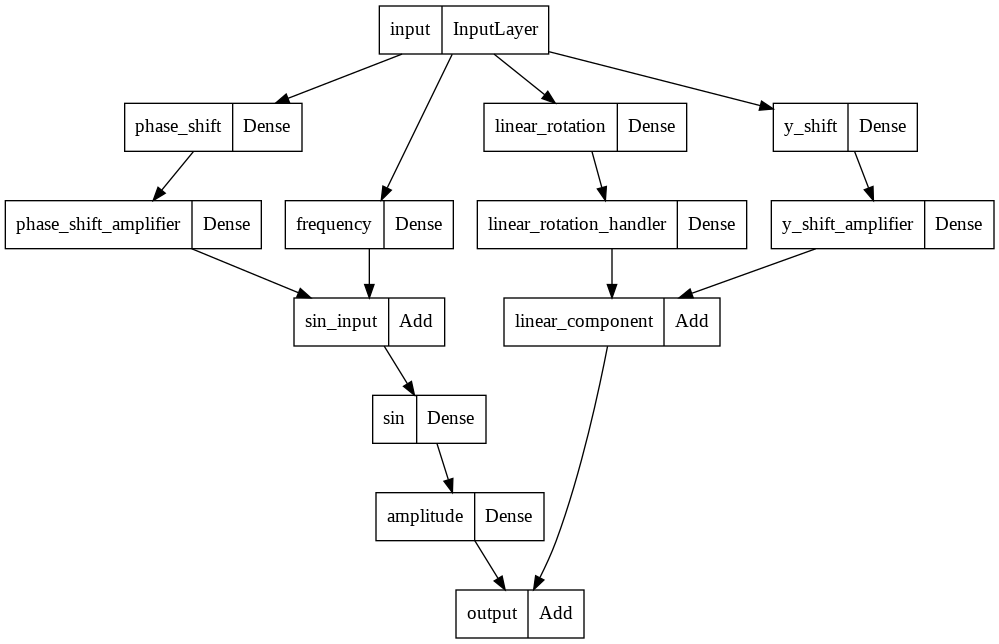

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.weights

[<tf.Variable 'phase_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Variable 'phase_shift/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'frequency/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.01720242]], dtype=float32)>,
 <tf.Variable 'phase_shift_amplifier/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'phase_shift_amplifier/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_rotation/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'y_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[73.73704]], dtype=float32)>,
 <tf.Variable 'y_shift/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_rotation_handler/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'y_shift_amplifier/kernel:0' shape=(1, 1) dtyp

# Forecast:  Test on a synthetic example

38/38 [==============================] - 0s 2ms/step


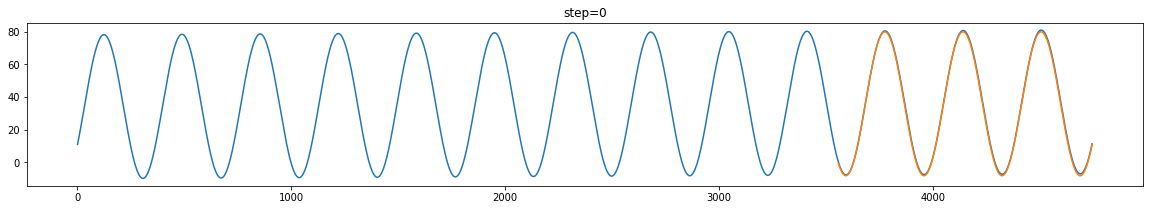

In [ ]:
for step in range(1):
  model.fit(
      X_train,
      y_train,
      epochs=50,
      verbose=False
      )
  y_pred = model.predict(X_test)
  model_mape =  mape(y_test, y_pred) * 100
  fig = plt.figure(figsize=(20,3))
  plt.plot(x.flatten(), y)
  plt.plot(X_test.flatten(), y_pred)
  plt.title(f'Step {step}. MAPE: {model_mape:.2f}')
  plt.show()

In [ ]:
model.weights

[<tf.Variable 'phase_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Variable 'phase_shift/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'frequency/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.01720242]], dtype=float32)>,
 <tf.Variable 'phase_shift_amplifier/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.3016492]], dtype=float32)>,
 <tf.Variable 'phase_shift_amplifier/bias:0' shape=(1,) dtype=float32, numpy=array([1.3016492], dtype=float32)>,
 <tf.Variable 'linear_rotation/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'y_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[73.73704]], dtype=float32)>,
 <tf.Variable 'y_shift/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_rotation_handler/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'y_shift_amplifier/kernel:0' sha

# Forecast: Test on real data

## Download data

In [ ]:
!pip install gdown --upgrade --quiet

In [ ]:
!gdown XXX -O data.zip

In [ ]:
!unzip data.zip

In [ ]:
MACHINE = 'colab'
LEN_N_FILL = 3
FIGSIZE = (20, 3)
START_DATE = '20110101'
MARKER_SIZE = 10  # matplotlib scatter plot
TRAIN_FRACTION = 0.8
PATH_PREFIX = 'XXX/XXX_TimeSeries_Prediction/' if MACHINE == 'local' else ''

In [ ]:
df = pd.read_excel(PATH_PREFIX + 'XXX/XXX.xlsx')
df.drop(columns=df.columns[0], inplace=True)
columns = []
for col in df:
  div, n = col.split('_')
  columns.append(f'{div}_{n.zfill(LEN_N_FILL)}')
df.columns = columns
df = df[sorted(columns)]
# for column_name in df:
#   plt.figure(figsize=FIGSIZE)
#   df[column_name].plot()
#   plt.title(column_name)
#   plt.show()

def get_Xy(df=df, plot=True):
  y = df.mean(axis='columns') #global average series
  start_date = pd.Timestamp(START_DATE)
  end_date = start_date + pd.Timedelta(len(y)-1, unit='D')
  x_date = pd.date_range(start_date, end_date)
  if plot:
    plt.figure(figsize=FIGSIZE)
    plt.plot(x_date, y)
    plt.title('Global Average')
    plt.show()
  return x_date, y

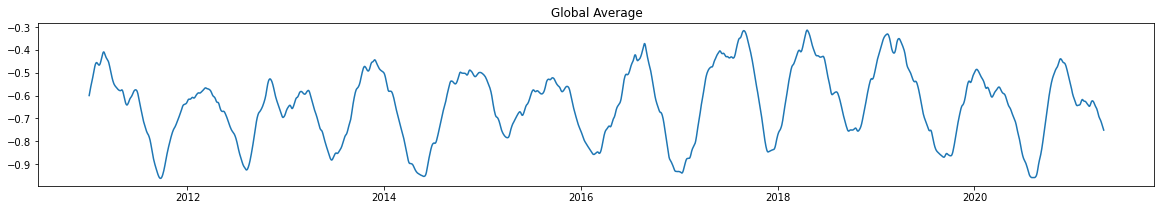

In [ ]:
x_date, y = get_Xy()
X_train, X_test, y_train, y_test = train_test_split(
    np.arange(len(y)).reshape(-1,1),
    y,
    shuffle=False)

## Create a model instance and run the fit-forecast cycles <br> (to illustrate how predictions change with epochs)

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 phase_shift (Dense)            (None, 1)            1           ['input[0][0]']                  
                                                                                                  
 frequency (Dense)              (None, 1)            1           ['input[0][0]']                  
                                                                                                  
 phase_shift_amplifier (Dense)  (None, 1)            1           ['phase_shift[0][0]']            
                                                                                           

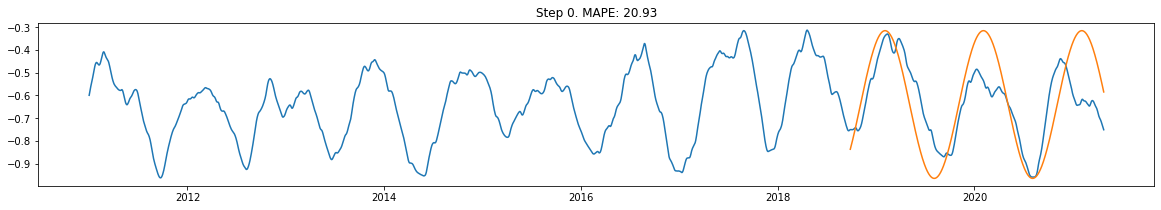

30/30 [==============================] - 0s 1ms/step


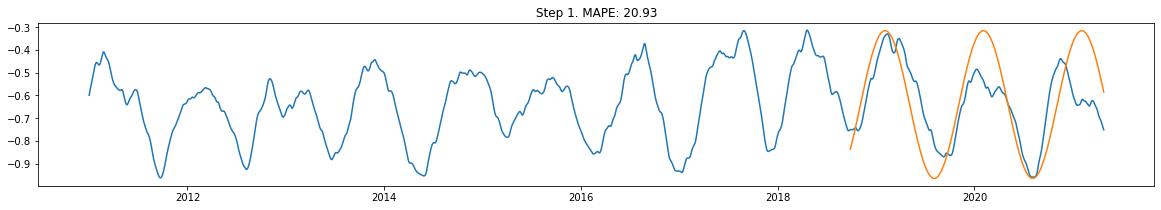

30/30 [==============================] - 0s 2ms/step


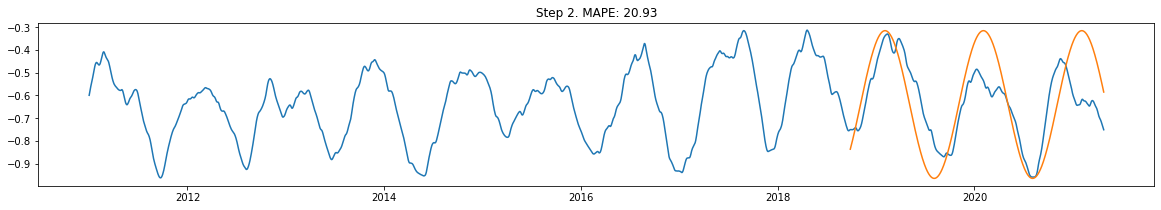

30/30 [==============================] - 0s 1ms/step


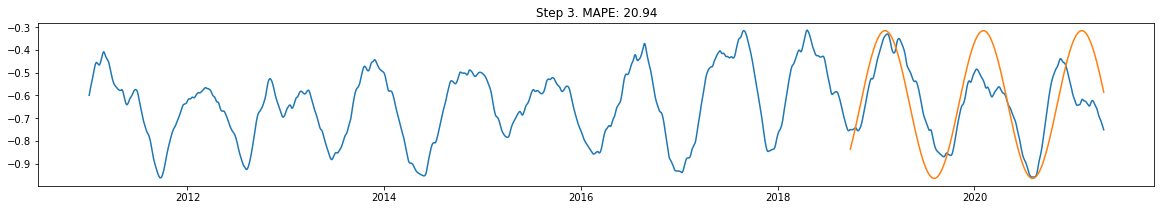

30/30 [==============================] - 0s 2ms/step


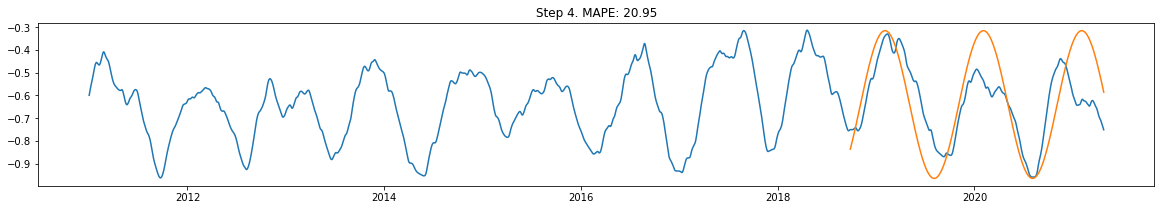

In [ ]:
model = get_sb_model(
    y_train,
    init_amplitude='auto',
    init_y_shift='auto',
    learning_rate=10**-4,
    trainability_map={
      'linear_rotation': False,
      'linear_rotation_handler': False,
      'y_shift': False,
      'y_shift_amplifier': False,
      'frequency': False,
      'phase_shift': True,
      'phase_shift_amplifier': True,
      'sin': False,
      'amplitude': False,
      'output': False
    }
    )

for step in range(5):
  model.fit(
      X_train,
      y_train,
      epochs=1,
      verbose=False
      )
  y_pred = model.predict(X_test)
  model_mape =  mape(y_test, y_pred) * 100
  fig = plt.figure(figsize=FIGSIZE)
  plt.plot(x_date, y)
  plt.plot(x_date[-len(X_test):], y_pred)
  plt.title(f'Step {step}. MAPE: {model_mape:.2f}')
  plt.show()

In [ ]:
model.weights

[<tf.Variable 'phase_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Variable 'frequency/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.01720242]], dtype=float32)>,
 <tf.Variable 'phase_shift_amplifier/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.00031968]], dtype=float32)>,
 <tf.Variable 'linear_rotation/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'y_shift/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-2.]], dtype=float32)>,
 <tf.Variable 'linear_rotation_handler/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'y_shift_amplifier/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'sin/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.]], dtype=float32)>,
 <tf.Variable 'amplitude/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.32467481]], dtype=float32)>]